In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from scipy.optimize import minimize
from FixedIncomeToolkit import FixedIncomeToolkit

In [2]:
toolkit = FixedIncomeToolkit()
# If you want live ECB data:
toolkit.init_ecb_fetcher()
df_yields = toolkit.fetch_ecb_yield_curve(start_period="2018-01-01", end_period="2023-12-31")
# Flatten/display column sample:
print("Available columns sample:", df_yields.columns[:20])
# For demo/if no internet: use synthetic or CSV:
# df_yields = pd.read_csv("treasury_eur_yields.csv", parse_dates=["Date"], index_col="Date")

Available columns sample: Index(['SR_10Y', 'SR_1Y', 'SR_20Y', 'SR_2Y', 'SR_30Y', 'SR_3M', 'SR_3Y',
       'SR_5Y', 'SR_6M'],
      dtype='object')


In [4]:
#choose maturities for NS fit
maturities_cols = ["SR_2Y","SR_5Y","SR_10Y"]
# If fetcher returned MultiIndex, fetcher already flattened, but ensure:
df_yields.columns = df_yields.columns.astype(str)
yield_df = df_yields[maturities_cols].dropna(how='all').copy()
# Convert column names to numeric years (2,5,10) and put yields in decimals
yield_df.columns = [float(c.replace("SR_","").replace("Y","")) for c in yield_df.columns]
yield_df = yield_df / 100.0
yield_df

,2.0,5.0,10.0
TIME_PERIOD,,,
2018-01-02,-0.006184,-0.001584,0.005376
2018-01-03,-0.006258,-0.001722,0.005218
2018-01-04,-0.006092,-0.001541,0.005327
2018-01-05,-0.006105,-0.001643,0.005235
2018-01-08,-0.006202,-0.001830,0.005069
...,...,...,...
2023-12-21,0.024791,0.019230,0.020473
2023-12-22,0.024244,0.018603,0.020193
2023-12-27,0.024242,0.018458,0.019876


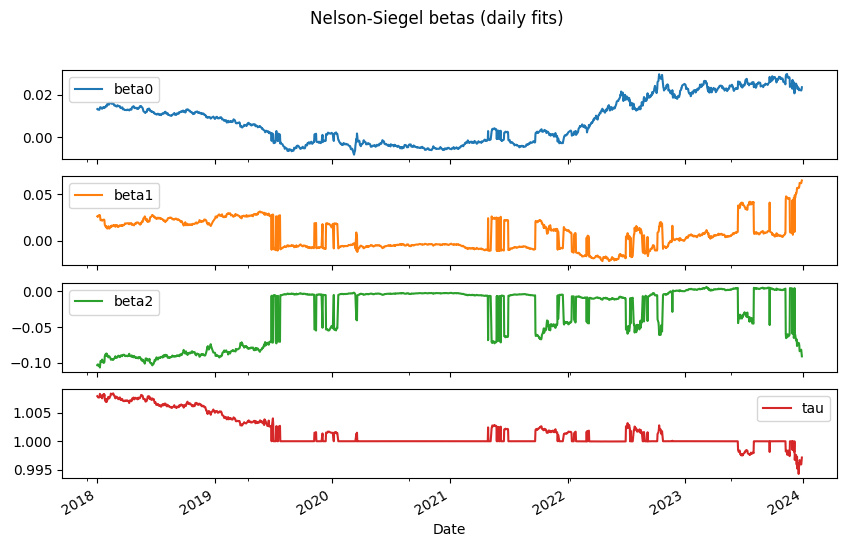

In [5]:
maturities = list(yield_df.columns.astype(float))  # [2,5,10]
ns_ts = toolkit.fit_ns_time_series(yield_df, maturities)
ns_ts.plot(subplots=True, figsize=(10,6), title="Nelson-Siegel betas (daily fits)")
plt.show()

Explained variances (first 3): [0.92164438 0.06839514 0.00996047]


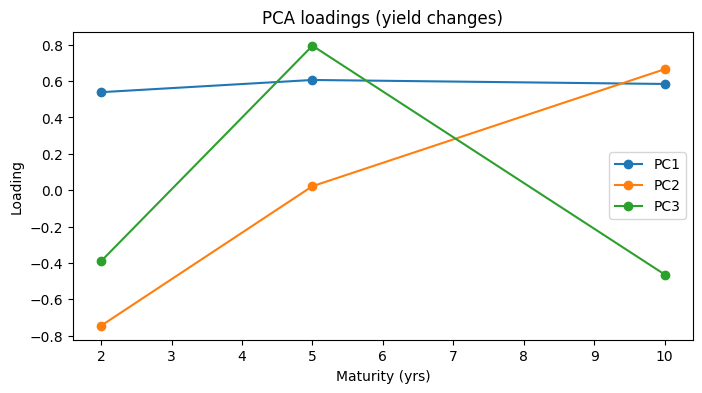

In [6]:
# Cell 4
pca = toolkit.pca_yield_changes(yield_df)
print("Explained variances (first 3):", pca["explained"])
# Plot first 3 loadings across maturities # level slope curvature
components = pca["components"]
mats = maturities
plt.figure(figsize=(8,4))
for i in range(min(3, components.shape[0])):
    plt.plot(mats, components[i,:], marker='o', label=f"PC{i+1}")
plt.xlabel("Maturity (yrs)"); plt.ylabel("Loading"); plt.title("PCA loadings (yield changes)")
plt.legend(); plt.show()

In [9]:
# Bootstrap zero curve (simple interpolation) and show discount factors
# example tenor points from last date
last_yields = yield_df.iloc[-1].to_dict()
zero_points = {float(k): float(v) for k,v in last_yields.items()}
zero_fn = toolkit.bootstrap_zero_curve_from_points(zero_points)
# show some discount factors
Tgrid = np.array([0.5,1,2,3,5,7,10])
z = zero_fn(Tgrid)
dfs = np.exp(-z * Tgrid)
pd.DataFrame({"T":Tgrid, "zero":z, "DF":dfs})


,T,zero,DF
0,0.5,0.024363,0.987892
1,1.0,0.024363,0.975931
2,2.0,0.024363,0.952441
3,3.0,0.022522,0.934667
4,5.0,0.018838,0.910111
5,7.0,0.019626,0.871636
6,10.0,0.020809,0.812135


In [10]:
toolkit.add_bond("2y", face=100, coupon_rate=0.01, maturity=2.0, freq=1)
toolkit.add_bond("5y", face=100, coupon_rate=0.02, maturity=5.0, freq=1)
toolkit.add_bond("10y", face=100, coupon_rate=0.025, maturity=10.0, freq=1)
# Use last NS params for pricing
last_params = tuple(ns_ts.iloc[-1].values)  # (beta0,beta1,beta2,tau)
for b in toolkit.bonds:
    b["ns_params"] = last_params
df_prices = toolkit.price_all_bonds()
print(df_prices)

  name       price  macaulay_duration  modified_duration  convexity  maturity  \
0   2y   97.157083           1.990114           1.990114   3.970341       2.0   
1   5y  100.402364           4.810500           4.810500  23.675497       5.0   
2  10y  103.585405           8.993795           8.993795  86.330561      10.0   

   coupon  
0   0.010  
1   0.020  
2   0.025  


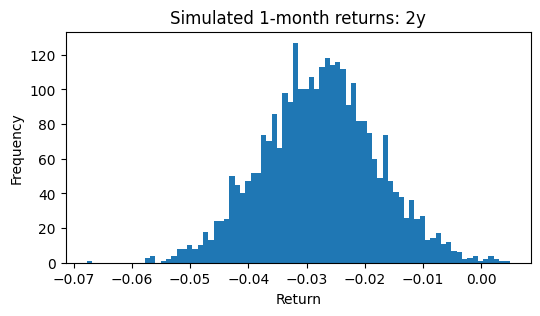

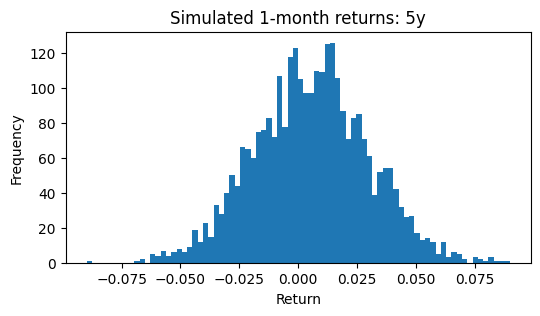

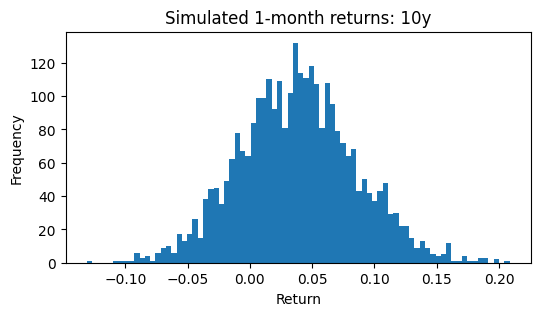

In [11]:
scenarios = toolkit.generate_scenario_returns_multi_factor(horizon_years=1/12, n_scenarios=3000,
                                                           level_vol=0.005, slope_vol=0.002, curvature_vol=0.001,
                                                           include_spread=True, spread_vol=0.0008, seed=42)
# show histograms for each bond
for i,b in enumerate(toolkit.bonds):
    plt.figure(figsize=(6,3))
    plt.hist(scenarios[:,i], bins=80)
    plt.title(f"Simulated 1-month returns: {b['name']}")
    plt.xlabel("Return"); plt.ylabel("Frequency")
    plt.show()


In [12]:
# pick target_duration from prices above (e.g., average)
target_duration = df_prices["modified_duration"].mean()
res_dict, lin_res, extras = toolkit.minimize_cvar(alpha=0.95, target_return=None, bounds=None, target_duration=target_duration, duration_tol=0.05)
print("Optimal weights:", res_dict["weights"])
print("CVaR:", res_dict["cvar"], "Mean ret:", res_dict["mean_return"], "Vol:", res_dict["vol"])

Optimal weights: [0.         0.90335304 0.09664696]
CVaR: 0.045176498953286834 Mean ret: 0.008746641878140598 Vol: 0.026402150992708522


Strategy mean: 0.10936509031762702 Bench mean: 0.10225198476948205


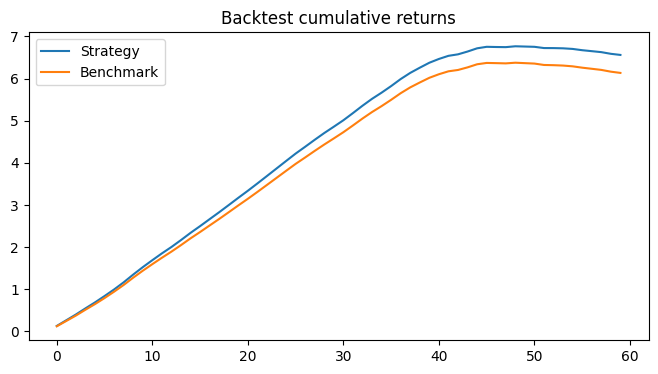

In [13]:
bt = toolkit.backtest_rolling(yield_df, maturities, window=252, rebalance_days=21,
                              alpha=0.95, target_duration=target_duration, duration_tol=0.2, tc=0.0005)
print("Strategy mean:", bt["strategy"].mean(), "Bench mean:", bt["benchmark"].mean())
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(bt["strategy"]), label="Strategy")
plt.plot(np.cumsum(bt["benchmark"]), label="Benchmark")
plt.legend(); plt.title("Backtest cumulative returns"); plt.show()

## DNS model with Kalman filter and curve forecasting

In [47]:
# EKF + RTS smoother implementation for Dynamic Nelson-Siegel (dynamic tau)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# -------------------------
# Helpers: NS curve + derivatives
# -------------------------
def ns_yields_from_state(state, maturities):
    """
    state: vector [beta0, beta1, beta2, log_tau]
           if length 3: [b0,b1,b2] and tau must be provided separately
    maturities: array of maturities in years
    returns: yields vector length = len(maturities)
    """
    if len(state) == 4:
        b0, b1, b2, log_tau = state
        tau = np.exp(log_tau)
    else:
        b0, b1, b2 = state
        raise ValueError("state must be length 4 (including log_tau)")

    t = np.array(maturities, dtype=float)
    x = t / tau
    # guard tiny x
    with np.errstate(divide='ignore', invalid='ignore'):
        L = (1 - np.exp(-x)) / x
        L = np.where(x == 0, 1.0, L)
    yields = b0 + b1 * L + b2 * (L - np.exp(-x))
    return yields

def ns_jacobian_wrt_state(state, maturities):
    """
    Returns Jacobian H = d y / d state  (shape: n_obs x 4) for state = [b0,b1,b2,log_tau]
    We compute analytical derivatives for b0,b1,b2, and use tau * d/dtau for log_tau.
    """
    b0, b1, b2, log_tau = state
    tau = np.exp(log_tau)
    t = np.array(maturities, dtype=float)
    x = t / tau
    # L and exp(-x)
    with np.errstate(divide='ignore', invalid='ignore'):
        expmx = np.exp(-x)
        L = (1 - expmx) / x
        L = np.where(x == 0, 1.0, L)

    # derivatives
    # dy/db0 = 1
    d_db0 = np.ones_like(t)

    # dy/db1 = L
    d_db1 = L

    # dy/db2 = L - exp(-x)
    d_db2 = L - expmx

    # dy/dlogtau = tau * dy/dtau
    # dy/dtau = b1 * dL/dtau + b2 * (dL/dtau - d/dtau exp(-x))
    # compute dL/dx first:
    # dL/dx = ( x*e^{-x} - (1 - e^{-x}) ) / x^2 = ( (x+1)e^{-x} - 1 ) / x^2
    # then dL/dtau = dL/dx * dx/dtau, and dx/dtau = -t / tau^2 = -x / tau
    with np.errstate(divide='ignore', invalid='ignore'):
        # handle x==0 gracefully by limiting values
        denom = np.where(x == 0, 1.0, x**2)
        dL_dx = ((x + 1.0) * expmx - 1.0) / denom
        dL_dx = np.where(x == 0, -1.0/2.0, dL_dx)  # small-x expansion: limit ~ -1/2
        dL_dtau = dL_dx * (-x / tau)  # chain rule

        # d/dtau exp(-x) = exp(-x) * d(-x)/dtau = exp(-x) * (t / tau^2) = exp(-x) * x / tau
        dexp_dtau = expmx * (x / tau)

        dy_dtau = b1 * dL_dtau + b2 * (dL_dtau - dexp_dtau)

        d_dlogtau = tau * dy_dtau

    # stack columns
    H = np.column_stack([d_db0, d_db1, d_db2, d_dlogtau])
    return H

# -------------------------
# EKF + RTS smoother
# -------------------------
def ekf_rts_smoother(yields, maturities, Q_scale=1e-6, R_scale=1e-6, phi=None, init_tau=2.5):
    """
    Extended Kalman Filter + Rauch-Tung-Striebel smoother for DNS with dynamic log_tau.
    - yields: T x N array (decimal)
    - maturities: length N array
    - Q_scale, R_scale: scale factors for process and observation noise (tune these)
    - phi: optional 4x4 transition matrix (if None -> identity random walk)
    - init_tau: initial tau guess (years)
    Returns:
      smoothed_states: T x 4 array [beta0,beta1,beta2, log_tau]
      filter_diagnostics: dict with forward preds if needed
    """
    Y = np.asarray(yields)
    T, N = Y.shape
    maturities = np.asarray(maturities, dtype=float)

    # State dimension
    k = 4

    # Transition matrix: AR(1) / random walk
    if phi is None:
        F = np.eye(k)
    else:
        F = np.asarray(phi, dtype=float)

    # Process noise covariance Q and observation noise R
    Q = np.eye(k) * Q_scale
    R = np.eye(N) * R_scale

    # initial state: fit static NS to first date to get starting betas and tau
    # fit quickly by least squares for b0,b1,b2 with tau=init_tau
    def fit_ns_once(y_row, tau_guess):
        t = maturities
        x = t / tau_guess
        with np.errstate(divide='ignore', invalid='ignore'):
            expmx = np.exp(-x)
            L = (1 - expmx) / x
            L = np.where(x == 0, 1.0, L)
        X = np.column_stack([np.ones_like(t), L, L - expmx])
        beta, _, _, _ = np.linalg.lstsq(X, y_row, rcond=None)
        return beta  # length 3

    beta0_init = fit_ns_once(Y[0], init_tau)
    x0 = np.zeros(k)
    x0[:3] = beta0_init
    x0[3] = np.log(init_tau)

    # initial covariance
    P0 = np.eye(k) * 1.0

    # allocate
    x_pred = np.zeros((T, k))
    P_pred = np.zeros((T, k, k))
    x_filt = np.zeros((T, k))
    P_filt = np.zeros((T, k, k))

    # forward EKF
    x_prev = x0.copy()
    P_prev = P0.copy()
    for t in range(T):
        # Prediction
        x_prior = F @ x_prev
        P_prior = F @ P_prev @ F.T + Q

        # compute predicted observation and jacobian at x_prior
        y_prior = ns_yields_from_state(x_prior, maturities)         # N
        H = ns_jacobian_wrt_state(x_prior, maturities)             # N x k

        # innovation covariance S = H P_prior H^T + R  (N x N)
        S = H @ P_prior @ H.T + R
        # Kalman gain K = P_prior H^T S^{-1}  (k x N)
        try:
            S_inv = np.linalg.inv(S)
        except np.linalg.LinAlgError:
            S_inv = np.linalg.pinv(S)
        K = P_prior @ H.T @ S_inv

        y_obs = Y[t]
        innov = y_obs - y_prior

        # Update
        x_upd = x_prior + K @ innov
        P_upd = (np.eye(k) - K @ H) @ P_prior

        # store
        x_pred[t] = x_prior
        P_pred[t] = P_prior
        x_filt[t] = x_upd
        P_filt[t] = P_upd

        # step
        x_prev = x_upd
        P_prev = P_upd

    # RTS smoother (backward pass)
    x_smooth = np.zeros_like(x_filt)
    P_smooth = np.zeros_like(P_filt)
    x_smooth[-1] = x_filt[-1]
    P_smooth[-1] = P_filt[-1]

    for t in range(T - 2, -1, -1):
        P_f = P_filt[t]
        P_p1 = P_pred[t + 1]
        # compute smoother gain
        try:
            inv_Pp1 = np.linalg.inv(P_p1)
        except np.linalg.LinAlgError:
            inv_Pp1 = np.linalg.pinv(P_p1)
        C = P_f @ F.T @ inv_Pp1
        x_smooth[t] = x_filt[t] + C @ (x_smooth[t + 1] - x_pred[t + 1])
        P_smooth[t] = P_f + C @ (P_smooth[t + 1] - P_p1) @ C.T

    smoothed_states = x_smooth  # T x k

    diagnostics = {
        "x_pred": x_pred, "P_pred": P_pred,
        "x_filt": x_filt, "P_filt": P_filt
    }

    return smoothed_states, diagnostics

# -------------------------
# VAR stochastic forecasting of smoothed states and reconstruct curves
# -------------------------
def var_forecast_reconstruct(smoothed_states, maturities, n_steps=10, n_scenarios=30, seed=1):
    """
    Fit VAR(1) on smoothed states (we use all 4 states, including log_tau),
    simulate n_scenarios forward n_steps, reconstruct yields.
    Returns:
      scenarios: array shape (n_scenarios, n_steps, n_maturities)
      forecast_mean: n_steps x n_maturities average across scenarios
    """
    rng = np.random.default_rng(seed)
    # use smoothed_states (T x 4)
    T, k = smoothed_states.shape

    # Fit VAR on states
    # use only beta0,beta1,beta2, log_tau (all columns)
    var_model = VAR(smoothed_states)
    var_res = var_model.fit(maxlags=1)
    coefs = var_res.coefs[0]  # k x k
    intercept = var_res.intercept  # length k
    resid_cov = np.cov(var_res.resid.T)

    scenarios = np.zeros((n_scenarios, n_steps, len(maturities)))
    for s in range(n_scenarios):
        x = smoothed_states[-1].copy()
        for t in range(n_steps):
            x = intercept + coefs @ x + rng.multivariate_normal(np.zeros(k), resid_cov)
            # reconstruct yields
            y = ns_yields_from_state(x, maturities)
            scenarios[s, t] = y

    forecast_mean = scenarios.mean(axis=0)
    return scenarios, forecast_mean

In [71]:
smoothed_states, diag = ekf_rts_smoother(
    yield_df.values,
    yield_df.columns.values,
    Q_scale=1e-6,   # increase for more responsiveness
    R_scale=9e-7,   # measurement noise scale
    init_tau=2.5
)


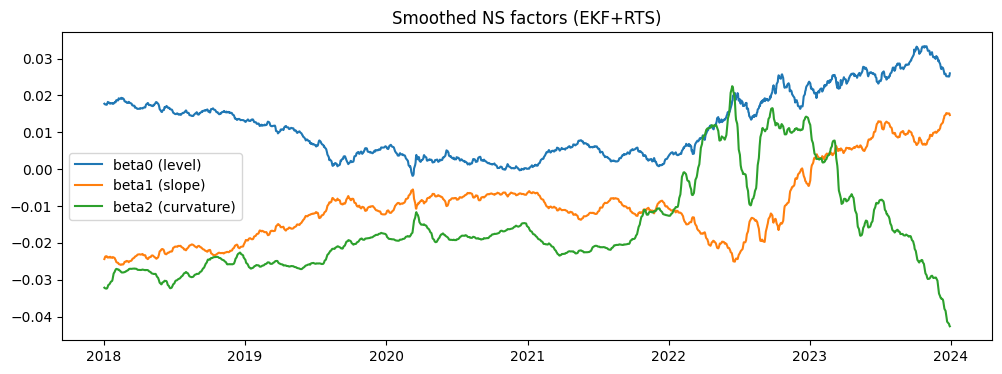

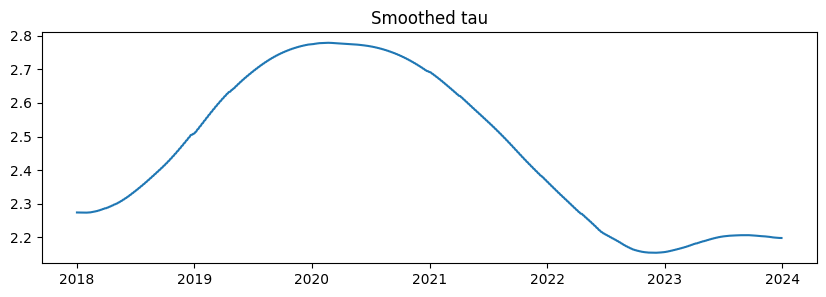

In [72]:
dates = yield_df.index
beta0 = smoothed_states[:,0]; beta1 = smoothed_states[:,1]; beta2 = smoothed_states[:,2]
tau_series = np.exp(smoothed_states[:,3])

plt.figure(figsize=(12,4))
plt.plot(dates, beta0, label='beta0 (level)')
plt.plot(dates, beta1, label='beta1 (slope)')
plt.plot(dates, beta2, label='beta2 (curvature)')
plt.legend(); plt.title("Smoothed NS factors (EKF+RTS)"); plt.show()

plt.figure(figsize=(10,3))
plt.plot(dates, tau_series, label='tau (dynamic)')
plt.title("Smoothed tau"); plt.show()

In [73]:
scenarios, forecast_mean = var_forecast_reconstruct(smoothed_states, yield_df.columns.values,
                                                     n_steps=5, n_scenarios=300, seed=42)


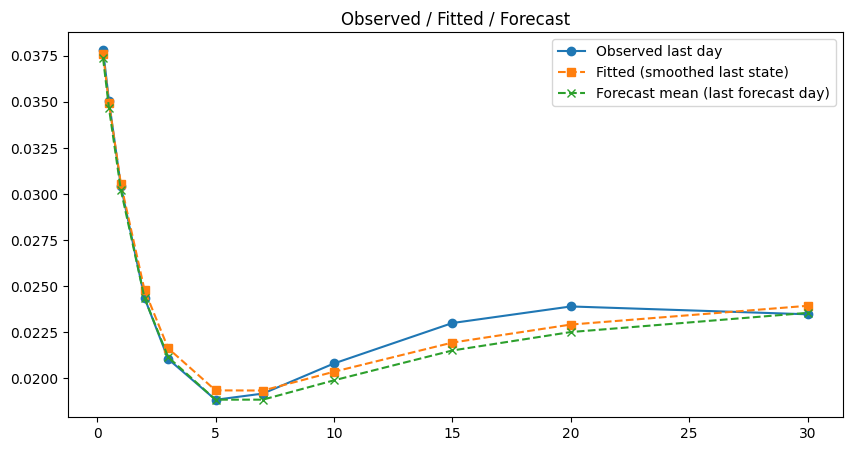

In [74]:
# Plot last observed vs fitted vs forecast mean last day
last_obs = yield_df.values[-1]
last_fitted = ns_yields_from_state(smoothed_states[-1], yield_df.columns.values)
last_forecast_mean = forecast_mean[-1]
#
plt.figure(figsize=(10,5))
plt.plot(yield_df.columns.values, last_obs, 'o-', label='Observed last day')
plt.plot(yield_df.columns.values, last_fitted, 's--', label='Fitted (smoothed last state)')
plt.plot(yield_df.columns.values, last_forecast_mean, 'x--', label='Forecast mean (last forecast day)')
plt.legend(); plt.title("Observed / Fitted / Forecast"); plt.show()
